# Modified MNIST classification challenge - Resnet50

We will use Resnet to try this shit 

## 1. Imports 

In [1]:
# Mount the google drive for the dataset 
from google.colab import drive
drive.mount('/content/drive') 
"""
4/sgHaKtMTGqfhccKVyUf1I2jMOFAEczj9b_gBKi5A2BHfDbtr-alpuPM
"""

Mounted at /content/drive


'\n4/sgHaKtMTGqfhccKVyUf1I2jMOFAEczj9b_gBKi5A2BHfDbtr-alpuPM\n'

In [2]:

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

keras = tf.keras


import os
import cv2
import time
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline


from glob import glob
from PIL import Image
from tqdm import tqdm_notebook
from resnets_utils import *
from sklearn.utils import shuffle
from sklearn.datasets import load_files   
from sklearn.model_selection import train_test_split 
from urllib.request import urlopen,urlretrieve


from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import load_model

from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)) 


TensorFlow 2.x selected.
True
True


Using TensorFlow backend.


## 2. Loading and pre-processing the dataset 

### 2.1 Load the data

In [3]:
## Read train and test images. NOTE: This is a bit slow.
t0 = time.time()
train_images = pd.read_pickle('./drive/My Drive/Colab Notebooks/Data/train_max_x') 
test_images = pd.read_pickle('./drive/My Drive/Colab Notebooks/Data/test_max_x')
train_labels = pd.read_csv("./drive/My Drive/Colab Notebooks/Data/train_max_y.csv").iloc[:,1]
LABELS= sorted(set(train_labels))
t1 = time.time()
print("Done in {} seconds".format(t1-t0))

# print(os.getcwd())
# files = [f for f in os.listdir('.') if os.path.isfile(f)]
# print(files)

Done in 10.509388446807861 seconds


In [4]:
print(train_labels.head(10))

0    6
1    7
2    2
3    9
4    7
5    8
6    7
7    6
8    8
9    8
Name: Label, dtype: int64


We can now see a couple of samples

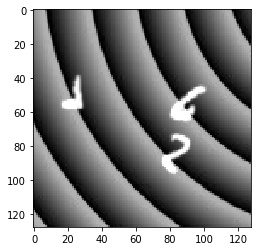

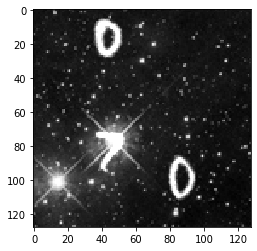

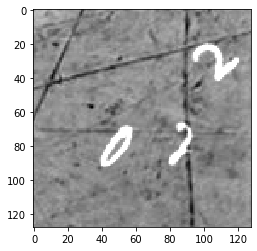

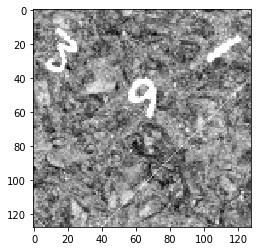

In [5]:
for i in range(4): 
    plt.figure()
    plt.imshow(train_images[i], cmap='gray')

Note the shapes of our datasets, and examine the labels as well. 



In [6]:
# Examine the shapes of our data 
print("Shape of training set: ", train_images.shape) 
print("Shape of test set: ", test_images.shape) 
print("Shape of our labels: ", train_labels.shape) 
print("Unique labels: ", LABELS)


Shape of training set:  (50000, 128, 128)
Shape of test set:  (10000, 128, 128)
Shape of our labels:  (50000,)
Unique labels:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### 2.3 Data Preprocessing 

Although some solid preprocessing work has already been done on these images, we still need to do a couple of things. 

1. We will reshape the data to a format tha the model can understand: (num_datapoints, dim1, dim2, channel)
2. We will further split the dataset in order to have some validation . This will also randomize the data. 
3. We will normalize the data to have values between 0 and 1. This will make a huge impact weh training. 

In [7]:
# Reshaping the images  
train_images = np.reshape( train_images, (50000, 128, 128, 1)) 
test_images = np.reshape( test_images, (10000, 128, 128, 1)) 
print("Shape of training set: ", train_images.shape) 
print("Shape of test set: ", test_images.shape) 


Shape of training set:  (50000, 128, 128, 1)
Shape of test set:  (10000, 128, 128, 1)


In [33]:
# further split into training and testing data
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(train_images, train_labels, 
                                                                    test_size=.1, # CHANGE: BEFORE 0.1
                                                                    random_state=42)

# normalize images 
X_train_new = X_train_new / 255.0 
X_test_new = X_test_new / 255.0

# convert data to tensors 
X_train_new = tf.convert_to_tensor(X_train_new, dtype=tf.float32)
X_test_new = tf.convert_to_tensor(X_test_new, dtype=tf.float32)
y_train_new = tf.keras.utils.to_categorical(y_train_new, num_classes=10)
y_test_new = tf.keras.utils.to_categorical(y_test_new, num_classes=10)

print("Shape of X_train_new {}".format(X_train_new.shape))
print("Shape of X_test_new {}".format(X_test_new.shape))


Shape of X_train_new (45000, 128, 128, 1)
Shape of X_test_new (5000, 128, 128, 1)


In [26]:
# Note that the classes have been one-ncoded to categorical
print(y_train_new[0])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


## 3. Loading the model: Resnet50V2



In [0]:
# obtain respective dimensions 
img_height, img_width = train_images.shape[1], train_images.shape[2] 
num_classes = 10  

base_model = applications.resnet_v2.ResNet50V2(weights=None, include_top=False, 
                                           input_shape=(img_height, img_width, 1))

**Note**: Messing up with the "Dropout" parameter affects convergence speed hugely, but also affect performance. 

In [30]:
x = base_model.output 
x = GlobalAveragePooling2D()(x) 
x = Dropout(0.6)(x) # latest parameter update
predictions = Dense(num_classes, activation='softmax')(x) 
model = Model(inputs = base_model.input, outputs= predictions)

In [31]:
from keras.optimizers import SGD, Adam
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary() 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [32]:
# Obtain the loss and accuracy before training : These metrics should be very bad

evaluation = model.evaluate(X_test_new, y_test_new)
print ("Loss = " + str(evaluation[0]))
print ("Test Accuracy = " + str(evaluation[1]))

500/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [14]:
## BEST MODEL CONFIGURATION SO FAR ##
# history = model.fit(X_train_new, y_train_new, 
#                     validation_data=(X_test_new, y_test_new), 
#                     epochs = 5+5, batch_size = 128)
## BEST MODEL CONFIGURATION SO FAR ##

## Current IDEA: 
# train the network for 3 epochs from scratch with dropout=0.6 
# retrain with dropout 0.7 for 5 epochs? ~90% , lots of variability 

## IDEA 2: Use Dropout 0.2 --> Seems to be a log more stable but also 
# final validation accuracy doesn't perform as well. acc < 90% 


# First training pass
history = model.fit(X_train_new, y_train_new, 
                    validation_data=(X_test_new, y_test_new), 
                    epochs = 14, batch_size = 32)

# THIS ATTEMPT: 

Train on 45000 samples, validate on 5000 samples
Epoch 1/14
45000/45000 [==============================] - 395s 9ms/sample - loss: 1.3084 - accuracy: 0.5483 - val_loss: 1.4227 - val_accuracy: 0.6586
Epoch 2/14
45000/45000 [==============================] - 385s 9ms/sample - loss: 0.5651 - accuracy: 0.8218 - val_loss: 0.5331 - val_accuracy: 0.8318
Epoch 3/14
45000/45000 [==============================] - 386s 9ms/sample - loss: 0.3841 - accuracy: 0.8883 - val_loss: 1.1871 - val_accuracy: 0.7248
Epoch 4/14
45000/45000 [==============================] - 386s 9ms/sample - loss: 0.3134 - accuracy: 0.9144 - val_loss: 0.6241 - val_accuracy: 0.8466
Epoch 5/14
45000/45000 [==============================] - 386s 9ms/sample - loss: 0.2505 - accuracy: 0.9321 - val_loss: 0.5802 - val_accuracy: 0.8418
Epoch 6/14
45000/45000 [==============================] - 381s 8ms/sample - loss: 0.2225 - accuracy: 0.9399 - val_loss: 0.3940 - val_accuracy: 0.8904
Epoch 7/14
45000/45000 [===========================

In [15]:
# # Second training pass: only activate if want to distribute training 
history2 = model.fit(X_train_new, y_train_new, 
                    validation_data=(X_test_new, y_test_new), 
                    epochs = 1, batch_size = 128)

Train on 45000 samples, validate on 5000 samples
45000/45000 [==============================] - 293s 7ms/sample - loss: 0.0323 - accuracy: 0.9914 - val_loss: 0.1338 - val_accuracy: 0.9690


？？？



## 3.1 Saving and loading the model  

Since training takes a lot of time, it is important to save models if we consider them important enough. We also indicate what's different in the name description. 

In [0]:
# Saving the model 
model.save('Modified_MNIST_keras_resnet_13plus1epochs_dropout0.6.h5') 

# # Loading the model 
# model = load_model('Modified_MNIST_keras_resnet_10epochs_dropout0.2.h5')

## 4. Evaluating the model 

In [17]:
evaluation = model.evaluate(X_test_new, y_test_new)
print ("Loss = " + str(evaluation[0]))
print ("Test Accuracy = " + str(evaluation[1]))

5000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## 4.1 Visualizing the metrics 

In order to see how our model behaves over time, we visualize botht the training and validation accuracy and loss over epochs time. 

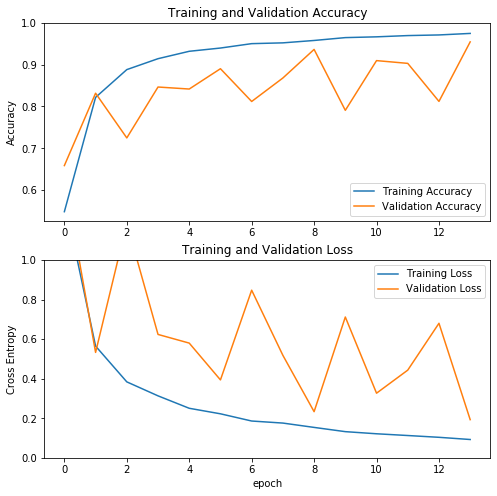

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('metrics_Modified_MNIST_keras_resnet_12epochs_dropout0.6.png')
plt.show()

## 5. Getting the Predictions 

Now that we have obtained a respectable model,  we are ready to output and export the predictions , which we will then submit on Kaggle. 

In [0]:
# We have to perform the same kind of transformations 
real_X_test = tf.convert_to_tensor(test_images, dtype=tf.float32)
real_X_test = test_images / 255.0
preds = model.predict(real_X_test)

Let's first check out a couple of predictions on the validation set! 

(10000, 128, 128, 1)
Prediction:  9
Prediction:  6
Prediction:  4
Prediction:  9


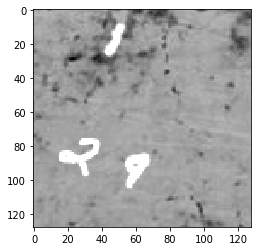

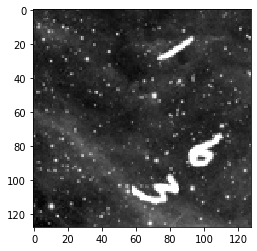

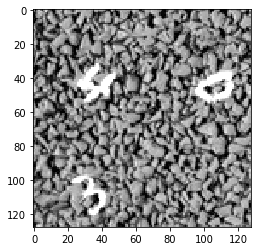

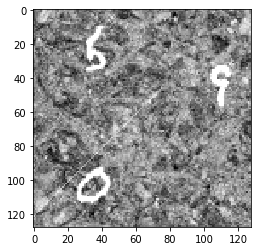

In [20]:
print(test_images.shape)
# Have to put the dimensions back as they were  
test_images = np.reshape(test_images, (10000,128,128))


for i in range(4): 
    plt.figure()
    plt.imshow(test_images[i], cmap='gray')
    print("Prediction: ", np.argmax(preds[i]))

Now we will convert this to a list of predictions , and then  download. 

In [21]:
predictions =  [np.argmax(pred) for pred in preds ]
ids = range(0,10000)
predictions = pd.DataFrame(zip(ids,predictions), columns=['Id','Label']) 
print(predictions.head())

   Id  Label
0   0      9
1   1      6
2   2      4
3   3      9
4   4      6


In [0]:
from google.colab import files
predictions.to_csv('predictions_resnet_14epochs_dropout0.6.csv', index=False)
files.download('predictions_resnet_14epochs_dropout0.6.csv') 

At this point, we can go ahead and save the model for later use.

In [0]:
# files.download('Modified_MNIST_keras_resnet_11plus1epochs_dropout0.6.h5')